In [39]:
from ultralytics import YOLO
import requests
from SPARQLWrapper import SPARQLWrapper, POST, TURTLE, JSON
import networkx as nx
import matplotlib.pyplot as plt
import rdflib
from datetime import datetime
import logging

In [40]:
YOLO_MODEL = 'yolo11x.pt'
FUSEKI_BASE_ENDPOINT = "http://localhost:3030"
DATASET_NAME = "yolo"
IMAGE_PATH = "D:\IA2S\RCRA\images\image.jpg"

<>:4: SyntaxWarning: invalid escape sequence '\I'
<>:4: SyntaxWarning: invalid escape sequence '\I'
C:\Users\PC\AppData\Local\Temp\ipykernel_8108\3440653831.py:4: SyntaxWarning: invalid escape sequence '\I'
  IMAGE_PATH = "D:\IA2S\RCRA\images\image.jpg"


In [41]:
# Fonction de détection d'objets
def yolo_detect_objects(image_path):
    logging.info(f"Démarrage de la détection d'objets pour l'image : {image_path}")
    try:
        model = YOLO('models/'+YOLO_MODEL)
        results = model(image_path, verbose=False)
        if not results or not results[0].boxes:
            logging.warning(f"Aucun objet détecté dans l'image : {image_path}")
            return []
        classes = [model.names[int(box.cls)] for box in results[0].boxes]
        logging.info(f"Classes détectées : {classes}")
        return classes
    except Exception as e:
        print(e)
        logging.error(f"Erreur lors de la détection d'objets : {e}")
        return []

In [42]:
# Fonction pour récupérer les relations depuis ConceptNet
def get_relations_from_conceptnet(concepts):
    base_url = "https://api.conceptnet.io/c/en/"
    graph = rdflib.Graph()

    logging.info("Démarrage de la récupération des relations ConceptNet pour les concepts.")
    CN = rdflib.Namespace("http://conceptnet.io")

    for concept in concepts:
        offset = 0
        limit = 2000
        logging.info(f"Récupération des relations pour le concept : {concept}")

        while True:
            # Construction de l'URL avec pagination
            url = f"{base_url}{concept}?limit={limit}&offset={offset}"
            try:
                logging.debug(f"Envoi de la requête à : {url}")
                response = requests.get(url)
                response.raise_for_status()  # Lève une exception si la réponse est une erreur
                data = response.json()
            except requests.exceptions.RequestException as e:
                logging.error(f"Échec de la requête pour le concept {concept} avec erreur : {e}")
                break
            
            # Parcours des relations récupérées et ajout dans le graphe RDF
            for edge in data.get("edges", []):
                rel = edge.get("rel", {}).get("@id", "")  # Récupération de la relation
                start = edge.get("start", {}).get("@id", "")  # Concept de départ
                end = edge.get("end", {}).get("@id", "")  # Concept d'arrivée

                if not rel or not start or not end:
                    continue

                # Création des URI pour les concepts et la relation dans le graphe RDF
                start_uri = CN[start]
                end_uri = CN[end]
                rel_uri = CN[rel]

                graph.add((start_uri, rel_uri, end_uri))
                logging.debug(f"Relation ajoutée : {start_uri} -> {rel_uri} -> {end_uri}")

            if len(data.get("edges", [])) < limit:
                logging.info(f"Toutes les relations pour le concept {concept} ont été récupérées.")
                break

            offset += limit

    logging.info("Récupération des relations ConceptNet terminée.")
    return graph

In [43]:
# Fonction pour insérer un graphe RDF dans Fuseki
def insert_rdf_to_fuseki(rdf_graph):
    logging.info("Démarrage de l'insertion du RDF dans Fuseki.")

    try:
        fuseki_endpoint = f"{FUSEKI_BASE_ENDPOINT}/{DATASET_NAME}/data"
        rdf_data = rdf_graph.serialize(format='turtle')  # Sérialisation du graphe RDF au format Turtle

        headers = {
            "Content-Type": "text/turtle"
        }

        logging.debug(f"RDF sérialisé : {rdf_data[:200]}...")

        # Envoi de la requête POST à Fuseki avec les données RDF
        response = requests.post(fuseki_endpoint, data=rdf_data, headers=headers)

        if response.status_code == 200:
            logging.info("Données RDF insérées avec succès dans Fuseki.")
        else:
            logging.error(f"Échec de l'insertion des données RDF dans Fuseki. Code de statut : {response.status_code}, Réponse : {response.text}")

    except Exception as e:
        logging.error(f"Erreur lors de l'insertion des données RDF dans Fuseki : {e}")

In [44]:
# Fonction pour extraire un graphe de connaissances (KG) basé sur des concepts
def KnGraph_extract(concepts):
    query = """
    PREFIX cn: <http://conceptnet.io/c/en/>
    SELECT ?subject ?predicate ?object
    WHERE {
        {
            ?subject ?predicate ?object .
            FILTER (?subject IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """) ||
                    ?object IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """))
        }
        UNION
        {
            ?subject ?predicate ?object .
            ?object ?predicate2 ?subject2 .
            FILTER (?subject IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """) ||
                    ?object IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """))
        }
    }
    LIMIT 1000
    """

    # Requête SPARQL pour extraire les relations de ConceptNet
    sparql = SPARQLWrapper(f"{FUSEKI_BASE_ENDPOINT}/{DATASET_NAME}/query")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    try:
        logging.debug("Envoi de la requête SPARQL pour récupérer les données.")
        results = sparql.query().convert()
        logging.info("Requête SPARQL exécutée avec succès.")
    except Exception as e:
        logging.error(f"Erreur lors de l'exécution de la requête SPARQL : {e}")
        return

    G = nx.Graph() 
    logging.info("Construction du graphe à partir des résultats de la requête.")

    # Construction du graphe à partir des résultats SPARQL
    for result in results["results"]["bindings"]:
        subject = result["subject"]["value"].split('/')[-1]
        predicate = result["predicate"]["value"].split('/')[-1]
        obj = result["object"]["value"].split('/')[-1]

        G.add_edge(subject, obj, label=predicate)  # Ajout d'une arête avec un label (relation)

    logging.info("Construction du graphe terminée. Suppression des nœuds non pertinents.")

    # Suppression des nœuds non pertinents (ceux qui sont isolés dans le contexte des concepts donnés)
    nodes_to_remove = []
    for node in G.nodes():
        related_concepts = [n for n in G[node] if any(concept == n for concept in concepts)]
        if len(related_concepts) == 1 and not any(concept == node for concept in concepts):
            nodes_to_remove.append(node)

    G.remove_nodes_from(nodes_to_remove)
    
    return G


In [45]:
def plt_KnGraph(concepts):
    G = KnGraph_extract(concepts)
    color_map = ['lightgreen' if node in concepts else 'yellow' for node in G.nodes()]
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.4)
    nx.draw(G, pos, node_color=color_map, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
    plt.title("Knowledge Graph")
    plt.axis("off")
    st.pyplot(plt)

In [46]:
def plot_KG(concepts):
    logging.info("Starting to plot the Knowledge Graph.")

    G = KnGraph_extract(concepts)

    # Assign colors to the nodes: highlight the concepts in light green
    color_map = []
    for node in G.nodes():
        if any(concept == node for concept in concepts):
            color_map.append('lightgreen')
        else:
            color_map.append('yellow')

    logging.info("Starting the visualization of the graph.")

    # Plot the graph using a spring layout
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.4)
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=1000)
    nx.draw_networkx_edges(G, pos, alpha=0.7)

    # Draw edge labels (relations between nodes)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Customize edge styles based on the relation type
    for u, v, data in G.edges(data=True):
        if data['label'] == 'IsA':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='black', style='dotted')
        elif data['label'] == 'relatedTo':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='black', style='dashed')
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='black', style='solid')

    # Draw node labels and customize the font properties
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    # Title and axis adjustments
    plt.title("Graph with Concepts Highlighted")
    plt.axis("off")
    plt.show()
    
    logging.info("Graph visualization complete.")

In [47]:
# Fonction de génération de description RDF
def generate_rdf_description(concepts):
    graph = KnGraph_extract(concepts)
    rdf_graph = rdflib.Graph()
    for u, v, data in graph.edges(data=True):
        subject = rdflib.URIRef(f"http://example.org/{u}")
        obj = rdflib.URIRef(f"http://example.org/{v}")
        predicate = rdflib.URIRef(f"http://example.org/{data['label']}")
        rdf_graph.add((subject, predicate, obj))
    return rdf_graph.serialize(format="turtle")

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s', 
    handlers=[
        logging.FileHandler('logs/'+datetime.now().strftime("log_%Y-%m-%d_%H-%M-%S.log"), encoding='utf-8')
    ]
)


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127862 (\N{SAKE BOTTLE AND CUP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


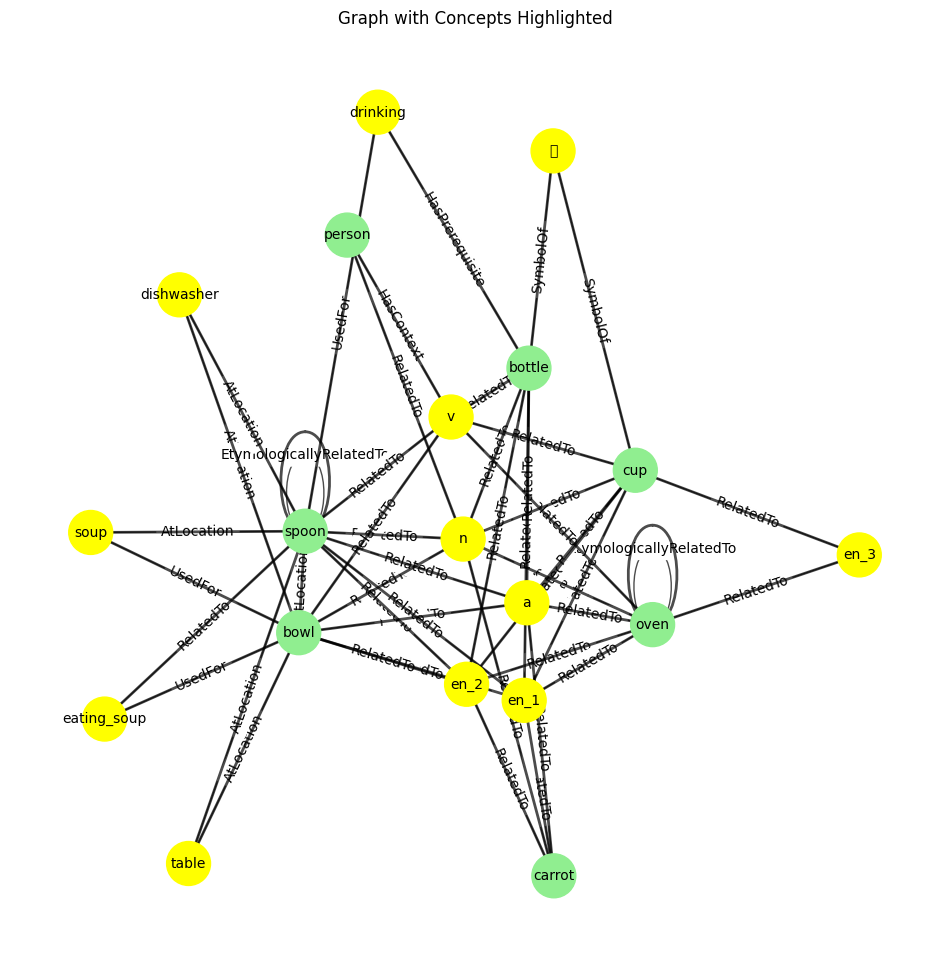

@prefix ns1: <http://example.org/> .

ns1:n ns1:RelatedTo ns1:bottle,
        ns1:bowl,
        ns1:carrot,
        ns1:cup,
        ns1:oven,
        ns1:person,
        ns1:spoon .

ns1:bottle ns1:HasPrerequisite ns1:drinking ;
    ns1:RelatedTo ns1:a,
        ns1:en_1,
        ns1:en_2,
        ns1:v ;
    ns1:SymbolOf <http://example.org/🍶> .

ns1:bowl ns1:AtLocation ns1:dishwasher,
        ns1:spoon,
        ns1:table ;
    ns1:RelatedTo ns1:a,
        ns1:en_1,
        ns1:en_2,
        ns1:v ;
    ns1:UsedFor ns1:eating_soup,
        ns1:soup .

ns1:cup ns1:RelatedTo ns1:a,
        ns1:en_1,
        ns1:en_2,
        ns1:en_3,
        ns1:v ;
    ns1:SymbolOf <http://example.org/🍶> .

ns1:person ns1:HasContext ns1:v .

ns1:oven ns1:EtymologicallyRelatedTo ns1:oven ;
    ns1:RelatedTo ns1:a,
        ns1:en_1,
        ns1:en_2,
        ns1:en_3,
        ns1:v .

ns1:carrot ns1:RelatedTo ns1:a .

ns1:en_1 ns1:RelatedTo ns1:carrot,
        ns1:spoon .

ns1:en_2 ns1:RelatedTo ns1:car

In [48]:
concepts = yolo_detect_objects(IMAGE_PATH)
rdf_graph = get_relations_from_conceptnet(concepts)
insert_rdf_to_fuseki(rdf_graph)
plot_KG(concepts)
description = generate_rdf_description(concepts)
print(description)